
# Evaluation: Competitive Ratio (Batch)
Loop over offline/online solutions and compute competitive ratios for each pair.


In [1]:

from pathlib import Path
import sys
import pandas as pd
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().resolve().parents[1]))
from motion_planning.utils.paths import OFFLINE_RESULTS_DIR, ONLINE_RESULTS_DIR
from motion_planning.evaluation.competitive_ratio import compute_competitive_ratio

# Ensure repo root and src on path
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "src" / "motion_planning").exists():
        REPO_ROOT = parent
        break
src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Repo root:", REPO_ROOT)


Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning



## Locate artifacts


In [2]:
from motion_planning.utils.paths import OFFLINE_RESULTS_DIR, ONLINE_RESULTS_DIR
from motion_planning.evaluation.competitive_ratio import compute_competitive_ratio
# Offline
offline_graph = sorted((OFFLINE_RESULTS_DIR / "solution details").glob("*_offline_graph_solution_edges.csv"))
offline_cand = sorted((OFFLINE_RESULTS_DIR / "problem details").glob("*_offline_candidates_opt.csv"))

# Online
online_graph = sorted((ONLINE_RESULTS_DIR / "graph-based").glob("*_online_ITM-ORB.csv"))
online_cand = sorted((ONLINE_RESULTS_DIR / "candidates").glob("*_online_*ORB.csv"))

print("Counts -> offline graph:", len(offline_graph), "offline cand:", len(offline_cand))
print("Counts -> online graph:", len(online_graph), "online cand:", len(online_cand))


Counts -> offline graph: 189 offline cand: 186
Counts -> online graph: 189 online cand: 378



## Competitive ratio for graph-based (utility)
Pair offline graph opt with online ITM-ORB by matching the base stem (before suffix).
CR = offline_utility / online_utility (utility objective).


In [3]:

# Build maps by base stem
offline_graph_map = {f.stem.replace("_offline_graph_solution_edges", ""): f for f in offline_graph}
online_graph_map = {f.stem.replace("_online_ITM-ORB", ""): f for f in online_graph}

records = []
for base, off_path in offline_graph_map.items():
    on_path = online_graph_map.get(base)
    if on_path is None:
        continue
    df_off = pd.read_csv(off_path)
    df_on = pd.read_csv(on_path)
    off_util = df_off.get("utility", pd.Series(dtype=float)).sum()
    on_util = df_on.get("utility", pd.Series(dtype=float)).sum()
    cr = compute_competitive_ratio(online_value=on_util, offline_value=off_util, objective="utility")
    records.append({
        "scenario": base,
        "offline_file": off_path.name,
        "online_file": on_path.name,
        "offline_utility": off_util,
        "online_utility": on_util,
        "cr_utility": cr,
    })

df_graph_cr = pd.DataFrame(records)
display(df_graph_cr)


,scenario,offline_file,online_file,offline_utility,online_utility,cr_utility
0,20251125_164202_Town03_Roundabout_10_mid_5,20251125_164202_Town03_Roundabout_10_mid_5_off...,20251125_164202_Town03_Roundabout_10_mid_5_onl...,1469.183927,1428.554274,1.028441
1,20251125_164202_Town03_Roundabout_15_mid_5,20251125_164202_Town03_Roundabout_15_mid_5_off...,20251125_164202_Town03_Roundabout_15_mid_5_onl...,1489.112909,1409.016311,1.056846
2,iter1_Town01_T-Intersection_10_high_5,iter1_Town01_T-Intersection_10_high_5_offline_...,iter1_Town01_T-Intersection_10_high_5_online_I...,1959.096658,1715.002914,1.142328
3,iter1_Town01_T-Intersection_10_low_5,iter1_Town01_T-Intersection_10_low_5_offline_g...,iter1_Town01_T-Intersection_10_low_5_online_IT...,1964.770385,1905.076454,1.031334
4,iter1_Town01_T-Intersection_10_medium_5,iter1_Town01_T-Intersection_10_medium_5_offlin...,iter1_Town01_T-Intersection_10_medium_5_online...,1962.970387,1824.750970,1.075747
...,...,...,...,...,...,...
184,iter2_Town05_Multiple_Intersections_20_very_hi...,iter2_Town05_Multiple_Intersections_20_very_hi...,iter2_Town05_Multiple_Intersections_20_very_hi...,2314.438546,818.846541,2.826462
185,iter2_Town05_Multiple_Intersections_5_high_5,iter2_Town05_Multiple_Intersections_5_high_5_o...,iter2_Town05_Multiple_Intersections_5_high_5_o...,2237.412546,463.570248,4.826480
186,iter2_Town05_Multiple_Intersections_5_low_5,iter2_Town05_Multiple_Intersections_5_low_5_of...,iter2_Town05_Multiple_Intersections_5_low_5_on...,2313.548246,2277.902338,1.015649
187,iter2_Town05_Multiple_Intersections_5_medium_5,iter2_Town05_Multiple_Intersections_5_medium_5...,iter2_Town05_Multiple_Intersections_5_medium_5...,2297.007399,1983.345243,1.158148


In [4]:
df_graph_cr.head()

,scenario,offline_file,online_file,offline_utility,online_utility,cr_utility
0,20251125_164202_Town03_Roundabout_10_mid_5,20251125_164202_Town03_Roundabout_10_mid_5_off...,20251125_164202_Town03_Roundabout_10_mid_5_onl...,1469.183927,1428.554274,1.028441
1,20251125_164202_Town03_Roundabout_15_mid_5,20251125_164202_Town03_Roundabout_15_mid_5_off...,20251125_164202_Town03_Roundabout_15_mid_5_onl...,1489.112909,1409.016311,1.056846
2,iter1_Town01_T-Intersection_10_high_5,iter1_Town01_T-Intersection_10_high_5_offline_...,iter1_Town01_T-Intersection_10_high_5_online_I...,1959.096658,1715.002914,1.142328
3,iter1_Town01_T-Intersection_10_low_5,iter1_Town01_T-Intersection_10_low_5_offline_g...,iter1_Town01_T-Intersection_10_low_5_online_IT...,1964.770385,1905.076454,1.031334
4,iter1_Town01_T-Intersection_10_medium_5,iter1_Town01_T-Intersection_10_medium_5_offlin...,iter1_Town01_T-Intersection_10_medium_5_online...,1962.970387,1824.750970,1.075747



## Competitive ratio for candidates-based (utility)
Pair offline candidates opt with each online candidates run (CZL/BAT). For each match, compute CR = offline_utility / online_utility.


In [5]:

offline_cand_map = {f.stem.replace("_offline_candidates_opt", ""): f for f in offline_cand}
# group online by base stem
online_cand_entries = []
for f in online_cand:
    stem = f.stem
    if "_online_" in stem:
        base, alg = stem.split("_online_", 1)
    else:
        base, alg = stem, "unknown"
    online_cand_entries.append((base, alg, f))

records_cand = []
for base, off_path in offline_cand_map.items():
    df_off = pd.read_csv(off_path)
    off_util = df_off.get("utility", pd.Series(dtype=float)).sum()
    for b, alg, on_path in online_cand_entries:
        if b != base:
            continue
        df_on = pd.read_csv(on_path)
        on_util = df_on.get("utility", pd.Series(dtype=float)).sum()
        cr = compute_competitive_ratio(online_value=on_util, offline_value=off_util, objective="utility")
        records_cand.append({
            "scenario": base,
            "algorithm": alg,
            "offline_file": off_path.name,
            "online_file": on_path.name,
            "offline_utility": off_util,
            "online_utility": on_util,
            "cr_utility": cr,
        })

df_cand_cr = pd.DataFrame(records_cand)
display(df_cand_cr)


,scenario,algorithm,offline_file,online_file,offline_utility,online_utility,cr_utility
0,20251125_164202_Town03_Roundabout_10_mid_5,BAT-ORB,20251125_164202_Town03_Roundabout_10_mid_5_off...,20251125_164202_Town03_Roundabout_10_mid_5_onl...,1469.183927,1408.900945,1.042787
1,20251125_164202_Town03_Roundabout_10_mid_5,CZL-ORB,20251125_164202_Town03_Roundabout_10_mid_5_off...,20251125_164202_Town03_Roundabout_10_mid_5_onl...,1469.183927,1408.900945,1.042787
2,20251125_164202_Town03_Roundabout_15_mid_5,BAT-ORB,20251125_164202_Town03_Roundabout_15_mid_5_off...,20251125_164202_Town03_Roundabout_15_mid_5_onl...,1489.112909,1468.740443,1.013871
3,20251125_164202_Town03_Roundabout_15_mid_5,CZL-ORB,20251125_164202_Town03_Roundabout_15_mid_5_off...,20251125_164202_Town03_Roundabout_15_mid_5_onl...,1489.112909,1468.740443,1.013871
4,iter1_Town01_T-Intersection_10_high_5,BAT-ORB,iter1_Town01_T-Intersection_10_high_5_offline_...,iter1_Town01_T-Intersection_10_high_5_online_B...,1959.096658,1899.528863,1.031359
...,...,...,...,...,...,...,...
367,iter2_Town05_Multiple_Intersections_5_low_5,CZL-ORB,iter2_Town05_Multiple_Intersections_5_low_5_of...,iter2_Town05_Multiple_Intersections_5_low_5_on...,2299.726144,2279.676832,1.008795
368,iter2_Town05_Multiple_Intersections_5_medium_5,BAT-ORB,iter2_Town05_Multiple_Intersections_5_medium_5...,iter2_Town05_Multiple_Intersections_5_medium_5...,2297.007399,2257.745814,1.017390
369,iter2_Town05_Multiple_Intersections_5_medium_5,CZL-ORB,iter2_Town05_Multiple_Intersections_5_medium_5...,iter2_Town05_Multiple_Intersections_5_medium_5...,2297.007399,2257.745814,1.017390
370,iter2_Town05_Multiple_Intersections_5_very_high_5,BAT-ORB,iter2_Town05_Multiple_Intersections_5_very_hig...,iter2_Town05_Multiple_Intersections_5_very_hig...,2189.904174,2183.483148,1.002941



## Unified solutions table
Build a single flattened DataFrame that aligns each scenario with its offline optima (graph + candidates) and online outputs (CZL, BAT, ITM), keeping per-solution details (nodes/edges/speeds, per-element risks/costs/utilities, and totals).


In [6]:

from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem

cand_dir = OFFLINE_RESULTS_DIR / "problem details"
graph_sol_dir = OFFLINE_RESULTS_DIR / "solution details"
online_cand_dir = ONLINE_RESULTS_DIR / "candidates"
online_graph_dir = ONLINE_RESULTS_DIR / "graph-based"

offline_graph = sorted(graph_sol_dir.glob("*_offline_graph_solution_edges.csv"))
offline_cand = sorted(cand_dir.glob("*_offline_candidates_opt.csv"))
online_cand_files = sorted(online_cand_dir.glob("*_online_*ORB.csv"))
online_graph_files = sorted(online_graph_dir.glob("*_online_ITM-ORB.csv"))

base = lambda path, suffix: path.stem.replace(suffix, "")

offline_graph_map = {base(p, "_offline_graph_solution_edges"): p for p in offline_graph}
offline_cand_map = {base(p, "_offline_candidates_opt"): p for p in offline_cand}

online_czl_map = {}
online_bat_map = {}
for p in online_cand_files:
    stem = p.stem
    if "_online_" in stem:
        scen, alg = stem.split("_online_", 1)
    else:
        scen, alg = stem, "unknown"
    alg_key = alg.lower()
    if "czl" in alg_key:
        online_czl_map[scen] = p
    elif "bat" in alg_key:
        online_bat_map[scen] = p

online_itm_map = {base(p, "_online_ITM-ORB"): p for p in online_graph_files}


def extract_solution(df: pd.DataFrame):
    sol = {}
    for col in ("risk", "cost", "utility"):
        if col in df.columns:
            series = pd.to_numeric(df[col], errors="coerce")
            sol[f"{col}s"] = series.tolist()
            sol[f"total_{col}"] = float(series.sum())
        else:
            sol[f"{col}s"] = None
            sol[f"total_{col}"] = None

    if {"start_node", "end_node"}.issubset(df.columns):
        sol["edges"] = list(zip(df["start_node"].astype(str), df["end_node"].astype(str)))
        sol["nodes"] = list(pd.unique(df[["start_node", "end_node"]].astype(str).values.ravel("K")))
    elif "path_nodes" in df.columns:
        sol["nodes"] = df["path_nodes"].tolist()
    else:
        sol["nodes"] = None

    if "speed" in df.columns:
        sol["speeds"] = df["speed"].tolist()
    elif "path_speeds" in df.columns:
        sol["speeds"] = df["path_speeds"].tolist()
    else:
        sol["speeds"] = None
    return sol


def ingest(path):
    if path is None:
        return None
    df = pd.read_csv(path)
    payload = extract_solution(df)
    payload["file"] = path.name
    payload["risk_budget"] = _parse_risk_budget_from_stem(path)
    return payload


all_bases = sorted(set().union(offline_graph_map, offline_cand_map, online_czl_map, online_bat_map, online_itm_map))
rows = []
for scen in all_bases:
    rows.append(
        {
            "scenario": scen,
            "offline_graph": ingest(offline_graph_map.get(scen)),
            "offline_cand": ingest(offline_cand_map.get(scen)),
            "online_czl": ingest(online_czl_map.get(scen)),
            "online_bat": ingest(online_bat_map.get(scen)),
            "online_itm": ingest(online_itm_map.get(scen)),
        }
    )

df_solutions = pd.json_normalize(rows, sep=".")
display(df_solutions.head())


,scenario,offline_graph.risks,offline_graph.total_risk,offline_graph.costs,offline_graph.total_cost,offline_graph.utilitys,offline_graph.total_utility,offline_graph.edges,offline_graph.nodes,offline_graph.speeds,...,online_itm.costs,online_itm.total_cost,online_itm.utilitys,online_itm.total_utility,online_itm.edges,online_itm.nodes,online_itm.speeds,online_itm.file,online_itm.risk_budget,offline_cand
0,20251125_164202_Town03_Roundabout_10_mid_5,"[0.001, 0.001, 0.8032650933641354, 0.001, 0.00...",8.680014,"[41.20844729159155, 1.2000002466582755, 11.208...",130.816073,"[58.79155270840845, 98.79999975334172, 88.7915...",1469.183927,"[(v_0_0, v_1_4), (v_1_4, v_2_4), (v_2_4, v_3_5...","[v_0_0, v_1_4, v_2_4, v_3_5, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[51.19999930253974, 1.200000218048756, 1.20000...",171.445726,"[48.80000069746026, 98.79999978195124, 98.7999...",1428.554274,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_5...","[v_0_0, v_1_5, v_2_5, v_3_5, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 20, 30, 30, 30, 30, 30, 3...",20251125_164202_Town03_Roundabout_10_mid_5_onl...,10.0,NaN
1,20251125_164202_Town03_Roundabout_15_mid_5,"[1.2878978795993672, 0.001, 0.001, 0.353215676...",12.313025,"[41.20844729159155, 1.2000002466582755, 1.2000...",110.887091,"[58.79155270840845, 98.79999975334172, 98.7999...",1489.112909,"[(v_0_0, v_1_4), (v_1_4, v_2_4), (v_2_4, v_3_4...","[v_0_0, v_1_4, v_2_4, v_3_4, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[51.19999930253974, 1.200000218048756, 1.20000...",190.983689,"[48.80000069746026, 98.79999978195124, 98.7999...",1409.016311,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_5...","[v_0_0, v_1_5, v_2_5, v_3_5, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",20251125_164202_Town03_Roundabout_15_mid_5_onl...,15.0,NaN
2,iter1_Town01_T-Intersection_10_high_5,"[0.001, 0.001, 0.3516686201299264, 0.001, 0.00...",9.902129,"[31.275011845347223, 1.1999945109098082, 31.91...",140.903342,"[68.72498815465278, 98.8000054890902, 68.08748...",1959.096658,"[(v_0_0, v_1_3), (v_1_3, v_2_3), (v_2_3, v_3_6...","[v_0_0, v_1_3, v_2_3, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 20, 30, 30, 25, 25, 20, 25, 10, 20, 3...",...,"[61.200000003928736, 1.2000000040738328, 1.200...",284.997086,"[38.799999996071264, 98.79999999592616, 98.799...",1715.002914,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_7, v_6...","[30, 30, 30, 30, 30, 30, 20, 30, 30, 30, 25, 3...",iter1_Town01_T-Intersection_10_high_5_online_I...,10.0,NaN
3,iter1_Town01_T-Intersection_10_low_5,"[3.2890156146175933, 0.001, 0.001, 0.001, 0.00...",9.469907,"[51.20844978457892, 1.1999981730191585, 1.2000...",135.229615,"[48.79155021542108, 98.80000182698085, 98.7999...",1964.770385,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_5...","[v_0_0, v_1_5, v_2_5, v_3_5, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[61.200000003928736, 1.2000000040738328, 1.200...",194.923546,"[38.799999996071264, 98.79999999592616, 98.799...",1905.076454,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_7, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",iter1_Town01_T-Intersection_10_low_5_online_IT...,10.0,NaN
4,iter1_Town01_T-Intersection_10_medium_5,"[0.4873315468299066, 0.001, 0.001, 0.598946912...",9.660454,"[51.20844978457892, 11.20844680902579, 1.20000...",137.029613,"[48.79155021542108, 88.79155319097421, 98.7999...",1962.970387,"[(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 25, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[61.200000003928736, 1.2000000040738328, 1.200...",275.249030,"[38.799999996071264, 98.79999999592616, 98.799...",1824.750970,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

In [7]:
len (offline_cand)

186

In [8]:
df_solutions.head(10)

,scenario,offline_graph.risks,offline_graph.total_risk,offline_graph.costs,offline_graph.total_cost,offline_graph.utilitys,offline_graph.total_utility,offline_graph.edges,offline_graph.nodes,offline_graph.speeds,...,online_itm.costs,online_itm.total_cost,online_itm.utilitys,online_itm.total_utility,online_itm.edges,online_itm.nodes,online_itm.speeds,online_itm.file,online_itm.risk_budget,offline_cand
0,20251125_164202_Town03_Roundabout_10_mid_5,"[0.001, 0.001, 0.8032650933641354, 0.001, 0.00...",8.680014,"[41.20844729159155, 1.2000002466582755, 11.208...",130.816073,"[58.79155270840845, 98.79999975334172, 88.7915...",1469.183927,"[(v_0_0, v_1_4), (v_1_4, v_2_4), (v_2_4, v_3_5...","[v_0_0, v_1_4, v_2_4, v_3_5, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[51.19999930253974, 1.200000218048756, 1.20000...",171.445726,"[48.80000069746026, 98.79999978195124, 98.7999...",1428.554274,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_5...","[v_0_0, v_1_5, v_2_5, v_3_5, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 20, 30, 30, 30, 30, 30, 3...",20251125_164202_Town03_Roundabout_10_mid_5_onl...,10.0,NaN
1,20251125_164202_Town03_Roundabout_15_mid_5,"[1.2878978795993672, 0.001, 0.001, 0.353215676...",12.313025,"[41.20844729159155, 1.2000002466582755, 1.2000...",110.887091,"[58.79155270840845, 98.79999975334172, 98.7999...",1489.112909,"[(v_0_0, v_1_4), (v_1_4, v_2_4), (v_2_4, v_3_4...","[v_0_0, v_1_4, v_2_4, v_3_4, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[51.19999930253974, 1.200000218048756, 1.20000...",190.983689,"[48.80000069746026, 98.79999978195124, 98.7999...",1409.016311,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_5...","[v_0_0, v_1_5, v_2_5, v_3_5, v_4_5, v_5_5, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",20251125_164202_Town03_Roundabout_15_mid_5_onl...,15.0,NaN
2,iter1_Town01_T-Intersection_10_high_5,"[0.001, 0.001, 0.3516686201299264, 0.001, 0.00...",9.902129,"[31.275011845347223, 1.1999945109098082, 31.91...",140.903342,"[68.72498815465278, 98.8000054890902, 68.08748...",1959.096658,"[(v_0_0, v_1_3), (v_1_3, v_2_3), (v_2_3, v_3_6...","[v_0_0, v_1_3, v_2_3, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 20, 30, 30, 25, 25, 20, 25, 10, 20, 3...",...,"[61.200000003928736, 1.2000000040738328, 1.200...",284.997086,"[38.799999996071264, 98.79999999592616, 98.799...",1715.002914,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_7, v_6...","[30, 30, 30, 30, 30, 30, 20, 30, 30, 30, 25, 3...",iter1_Town01_T-Intersection_10_high_5_online_I...,10.0,NaN
3,iter1_Town01_T-Intersection_10_low_5,"[3.2890156146175933, 0.001, 0.001, 0.001, 0.00...",9.469907,"[51.20844978457892, 1.1999981730191585, 1.2000...",135.229615,"[48.79155021542108, 98.80000182698085, 98.7999...",1964.770385,"[(v_0_0, v_1_5), (v_1_5, v_2_5), (v_2_5, v_3_5...","[v_0_0, v_1_5, v_2_5, v_3_5, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[61.200000003928736, 1.2000000040738328, 1.200...",194.923546,"[38.799999996071264, 98.79999999592616, 98.799...",1905.076454,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_7, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",iter1_Town01_T-Intersection_10_low_5_online_IT...,10.0,NaN
4,iter1_Town01_T-Intersection_10_medium_5,"[0.4873315468299066, 0.001, 0.001, 0.598946912...",9.660454,"[51.20844978457892, 11.20844680902579, 1.20000...",137.029613,"[48.79155021542108, 88.79155319097421, 98.7999...",1962.970387,"[(v_0_0, v_1_5), (v_1_5, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_5, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 25, 30, 30, 30, 30, 30, 30, 30, 3...",...,"[61.200000003928736, 1.2000000040738328, 1.200...",275.249030,"[38.799999996071264, 98.79999999592616, 98.799...",1824.750970,"[(v_0_0, v_1_6), (v_1_6, v_2_6), (v_2_6, v_3_6...","[v_0_0, v_1_6, v_2_6, v_3_6, v_4_6, v_5_6, v_6...","[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,


## Competitive ratios (utility)
Leverage the unified table to compare each online run against both offline optima (candidates-based and graph-based).


In [9]:


def _safe_cr(row, online_prefix: str, offline_prefix: str):
    online_val = row.get(f"{online_prefix}.total_utility")
    offline_val = row.get(f"{offline_prefix}.total_utility")
    if online_val is None or offline_val is None:
        return None
    if pd.isna(online_val) or pd.isna(offline_val):
        return None
    return compute_competitive_ratio(
        online_value=float(online_val),
        offline_value=float(offline_val),
        objective="utility",
    )


df_cr = df_solutions.copy()
df_cr["cr_czl_opt_cand"] = df_cr.apply(lambda r: _safe_cr(r, "online_czl", "offline_cand"), axis=1)
df_cr["cr_czl_opt_graph"] = df_cr.apply(lambda r: _safe_cr(r, "online_czl", "offline_graph"), axis=1)
df_cr["cr_bat_opt_cand"] = df_cr.apply(lambda r: _safe_cr(r, "online_bat", "offline_cand"), axis=1)
df_cr["cr_bat_opt_graph"] = df_cr.apply(lambda r: _safe_cr(r, "online_bat", "offline_graph"), axis=1)
df_cr["cr_itm_opt_cand"] = df_cr.apply(lambda r: _safe_cr(r, "online_itm", "offline_cand"), axis=1)
df_cr["cr_itm_opt_graph"] = df_cr.apply(lambda r: _safe_cr(r, "online_itm", "offline_graph"), axis=1)

display(
    df_cr[
        [
            "scenario",
            "cr_czl_opt_cand",
            "cr_czl_opt_graph",
            "cr_bat_opt_cand",
            "cr_bat_opt_graph",
            "cr_itm_opt_cand",
            "cr_itm_opt_graph",
        ]
    ]
)


,scenario,cr_czl_opt_cand,cr_czl_opt_graph,cr_bat_opt_cand,cr_bat_opt_graph,cr_itm_opt_cand,cr_itm_opt_graph
0,20251125_164202_Town03_Roundabout_10_mid_5,1.042787,1.042787,1.042787,1.042787,1.028441,1.028441
1,20251125_164202_Town03_Roundabout_15_mid_5,1.013871,1.013871,1.013871,1.013871,1.056846,1.056846
2,iter1_Town01_T-Intersection_10_high_5,1.031359,1.031359,1.031359,1.031359,1.142328,1.142328
3,iter1_Town01_T-Intersection_10_low_5,1.031398,1.031398,1.031398,1.031398,1.031334,1.031334
4,iter1_Town01_T-Intersection_10_medium_5,1.043902,1.043902,1.043902,1.043902,1.075747,1.075747
...,...,...,...,...,...,...,...
184,iter2_Town05_Multiple_Intersections_20_very_hi...,1.092189,1.092375,1.092189,1.092375,2.825981,2.826462
185,iter2_Town05_Multiple_Intersections_5_high_5,1.009610,1.023311,1.009610,1.023311,4.761856,4.826480
186,iter2_Town05_Multiple_Intersections_5_low_5,1.008795,1.014858,1.008795,1.014858,1.009581,1.015649
187,iter2_Town05_Multiple_Intersections_5_medium_5,1.017390,1.017390,1.017390,1.017390,1.158148,1.158148



## Save competitive ratios
Persist the competitive ratio table for downstream analysis/plots.


In [10]:

from motion_planning.utils.paths import RESULTS_DIR

save_dir = RESULTS_DIR / "evaluation"
save_dir.mkdir(parents=True, exist_ok=True)
cr_csv = save_dir / "competitive_ratios.csv"
df_cr.to_csv(cr_csv, index=False)
print(f"Saved competitive ratios to {cr_csv}")


Saved competitive ratios to /home/abdulrahman/competitive-online-algorithms-motion-planning/results/evaluation/competitive_ratios.csv



## Box plots by scenario and budget
For each scenario, show competitive ratio distributions at each budget, grouped by algorithm (different colors). Multiple runs/risk levels per budget appear inside the box.


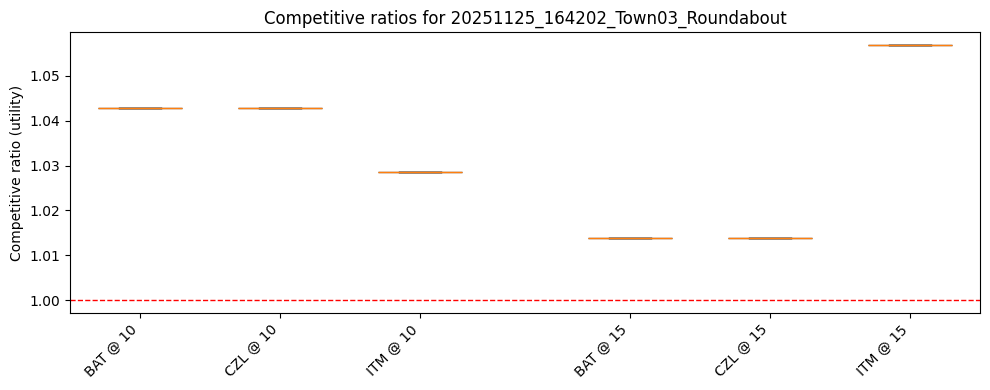

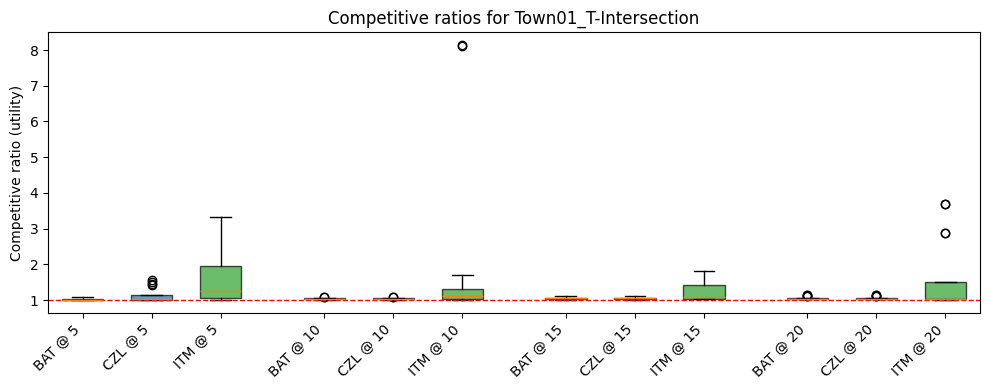

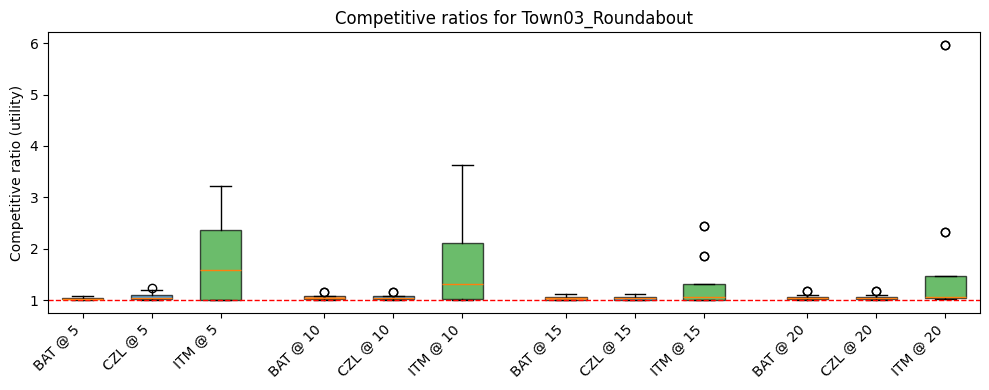

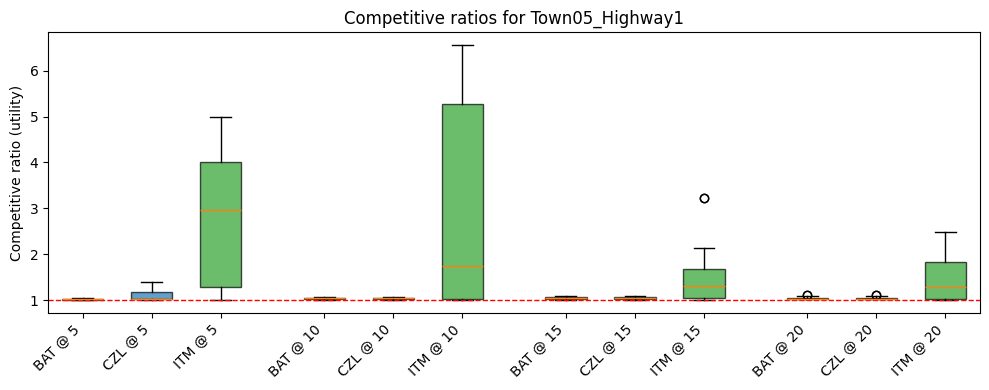

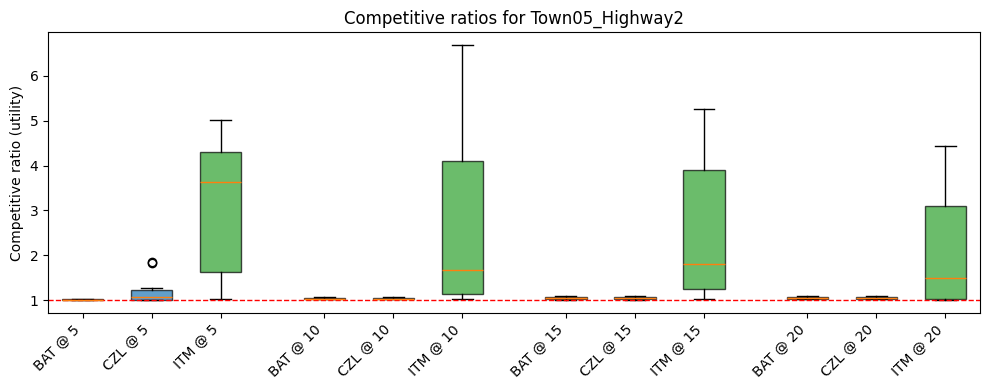

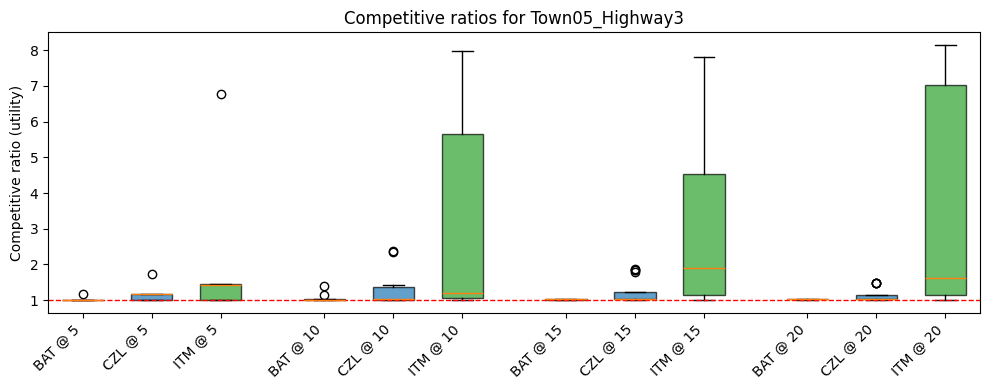

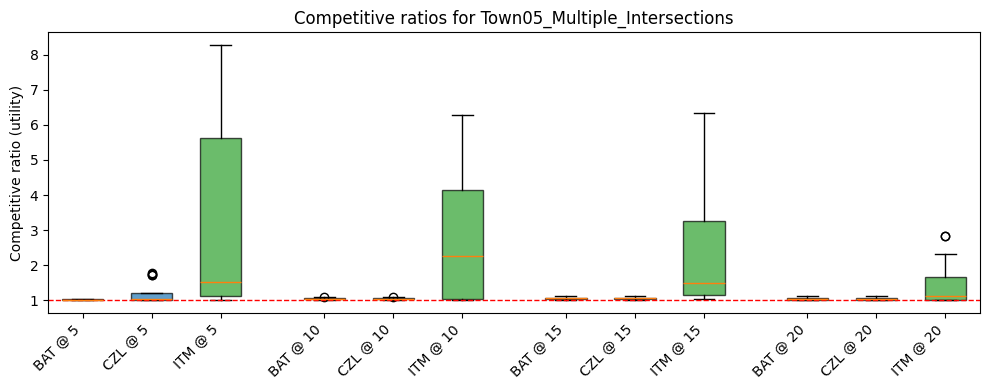

In [11]:

import matplotlib.pyplot as plt

risk_labels = {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}


def parse_meta(stem: str):
    parts = stem.split("_")
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem, None
    budget = None
    try:
        budget = float(parts[risk_idx - 1])
    except Exception:
        budget = None
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith("iter") else parts[: risk_idx - 1]
    scenario = "_".join(scen_parts) or stem
    return scenario, budget


cr_cols = [
    "cr_czl_opt_cand",
    "cr_czl_opt_graph",
    "cr_bat_opt_cand",
    "cr_bat_opt_graph",
    "cr_itm_opt_cand",
    "cr_itm_opt_graph",
]

long_df = df_cr.melt(id_vars=["scenario"], value_vars=cr_cols, var_name="metric", value_name="cr")
long_df = long_df.dropna(subset=["cr"])
long_df["algorithm"] = long_df["metric"].str.split("_").str[1].str.upper()
long_df["offline_ref"] = long_df["metric"].str.split("_").str[-1]
meta = long_df["scenario"].apply(parse_meta)
long_df["scenario_name"] = meta.apply(lambda x: x[0])
long_df["budget"] = meta.apply(lambda x: x[1])

alg_colors = {"CZL": "#1f77b4", "BAT": "#ff7f0e", "ITM": "#2ca02c"}

for scen in sorted(long_df["scenario_name"].dropna().unique()):
    sub = long_df[long_df["scenario_name"] == scen]
    if sub.empty:
        continue
    budgets = sorted([b for b in sub["budget"].dropna().unique()])
    data = []
    positions = []
    labels = []
    label_algs = []
    pos = 1
    for b in budgets:
        for alg in sorted(sub["algorithm"].unique()):
            vals = sub[(sub["budget"] == b) & (sub["algorithm"] == alg)]["cr"].dropna()
            if vals.empty:
                continue
            data.append(vals)
            positions.append(pos)
            labels.append(f"{alg} @ {int(b) if b.is_integer() else b}")
            label_algs.append(alg)
            pos += 1
        pos += 0.5  # gap between budgets

    if not data:
        continue

    plt.figure(figsize=(10, 4))
    bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
    for patch, alg in zip(bp['boxes'], label_algs):
        patch.set_facecolor(alg_colors.get(alg, "#888888"))
        patch.set_alpha(0.7)
    plt.axhline(1.0, color="red", linestyle="--", linewidth=1)
    plt.xticks(positions, labels, rotation=45, ha="right")
    plt.ylabel("Competitive ratio (utility)")
    plt.title(f"Competitive ratios for {scen}")
    plt.tight_layout()
    plt.show()


# Candidates-based competitive ratios
Visualize competitive ratios only for candidates-based problems (offline reference = candidates opt).

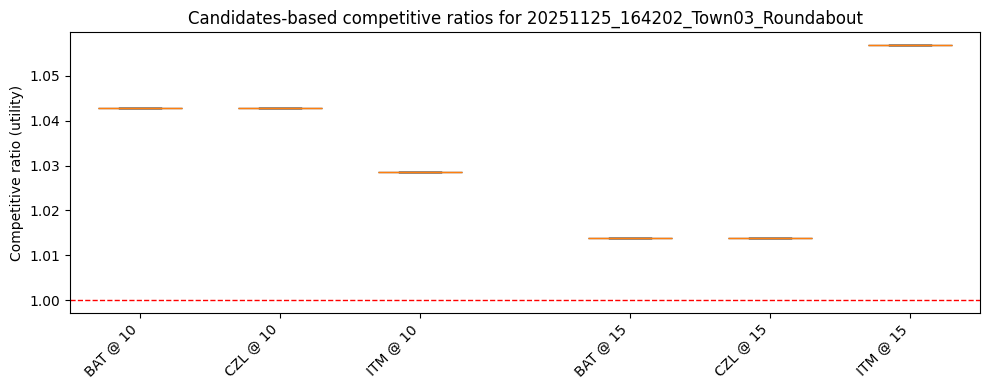

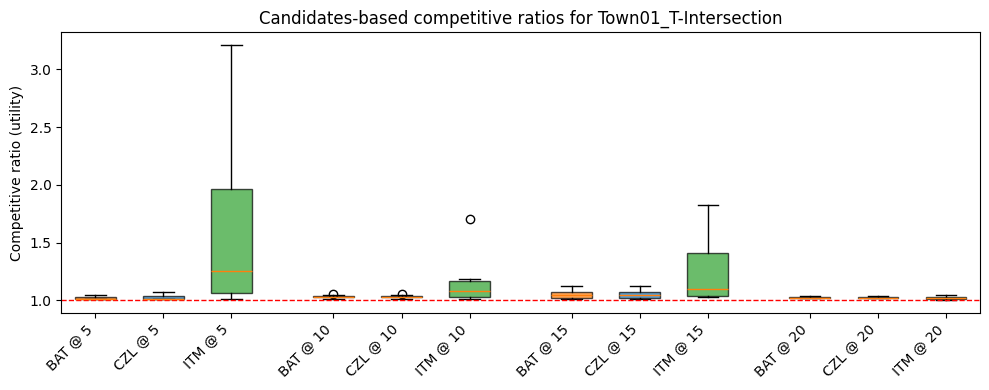

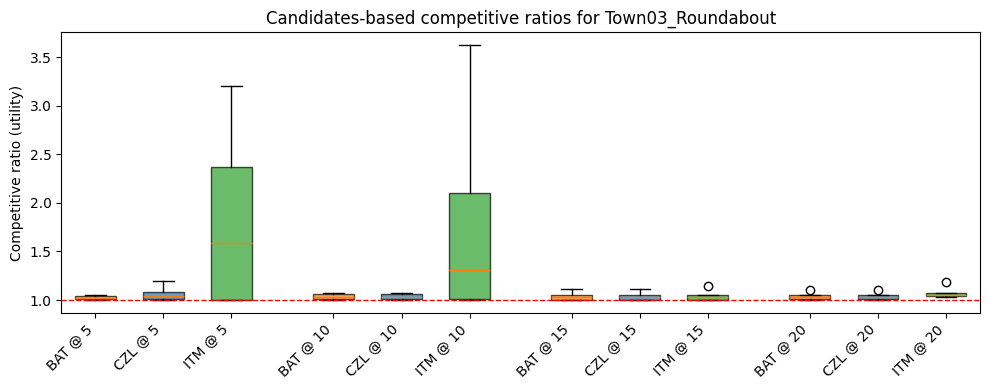

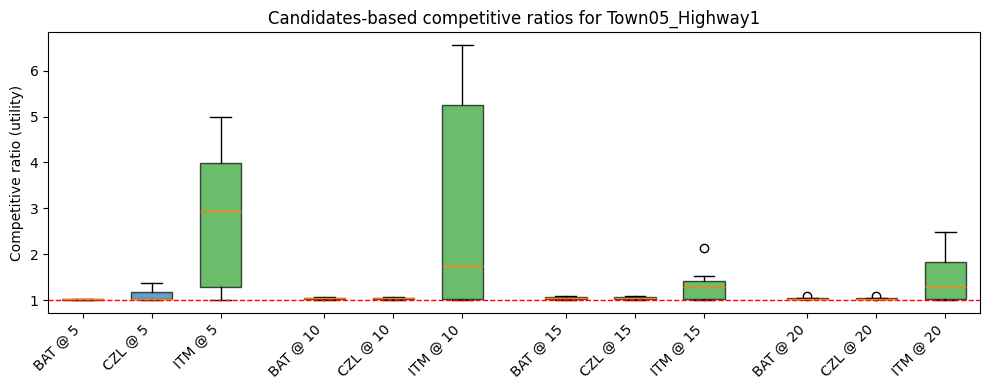

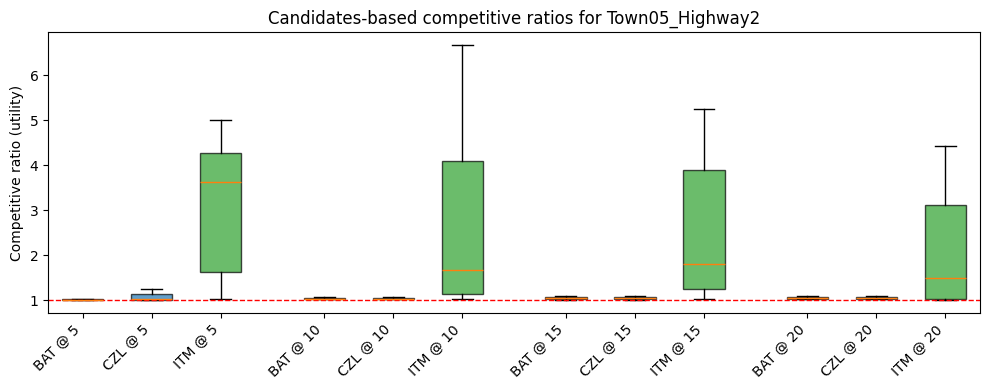

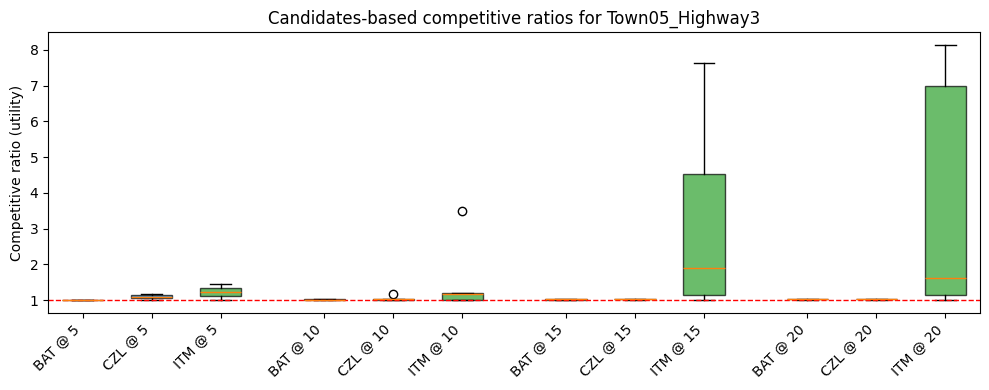

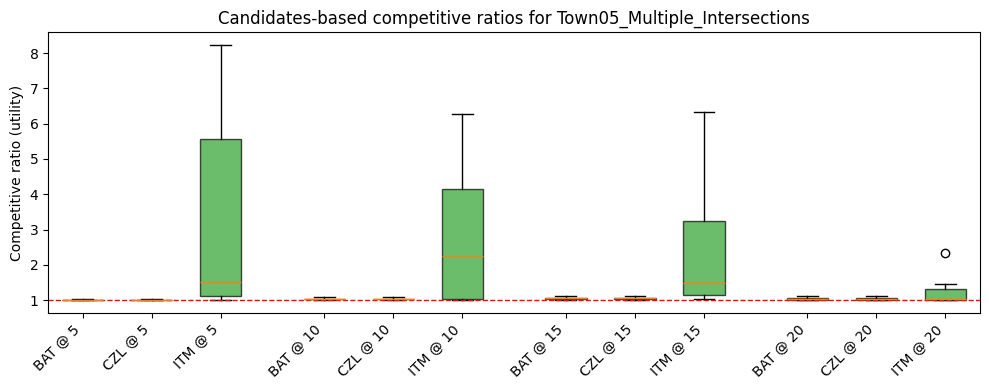

In [12]:
cand_df = long_df[long_df["offline_ref"] == "cand"].copy()
if cand_df.empty:
    print("No candidate-based competitive ratio rows found.")
else:
    colors = alg_colors if 'alg_colors' in globals() else {"CZL": "#1f77b4", "BAT": "#ff7f0e", "ITM": "#2ca02c"}
    def drop_outliers(series, k=1.5):
        if series.empty:
            return series
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - k * iqr, q3 + k * iqr
        return series[(series >= low) & (series <= high)]
    for scen in sorted(cand_df["scenario_name"].dropna().unique()):
        sub = cand_df[cand_df["scenario_name"] == scen]
        budgets = sorted([b for b in sub["budget"].dropna().unique()])
        data, positions, labels, label_algs = [], [], [], []
        pos = 1
        for b in budgets:
            for alg in sorted(sub["algorithm"].unique()):
                vals = sub[(sub["budget"] == b) & (sub["algorithm"] == alg)]["cr"].dropna()
                vals = drop_outliers(vals)
                if vals.empty:
                    continue
                data.append(vals)
                positions.append(pos)
                labels.append(f"{alg} @ {int(b) if b.is_integer() else b}")
                label_algs.append(alg)
                pos += 1
            pos += 0.5
        if not data:
            print(f"Skipping {scen}: no candidate-based CR values.")
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch, alg in zip(bp['boxes'], label_algs):
            patch.set_facecolor(colors.get(alg, "#888888"))
            patch.set_alpha(0.7)
        plt.axhline(1.0, color="red", linestyle="--", linewidth=1)
        plt.xticks(positions, labels, rotation=45, ha="right")
        plt.ylabel("Competitive ratio (utility)")
        plt.title(f"Candidates-based competitive ratios for {scen}")
        plt.tight_layout()
        plt.show()


# CZL vs BAT (candidates-only)
Box compare competitive ratios for CZL vs BAT using candidates-based offline reference.

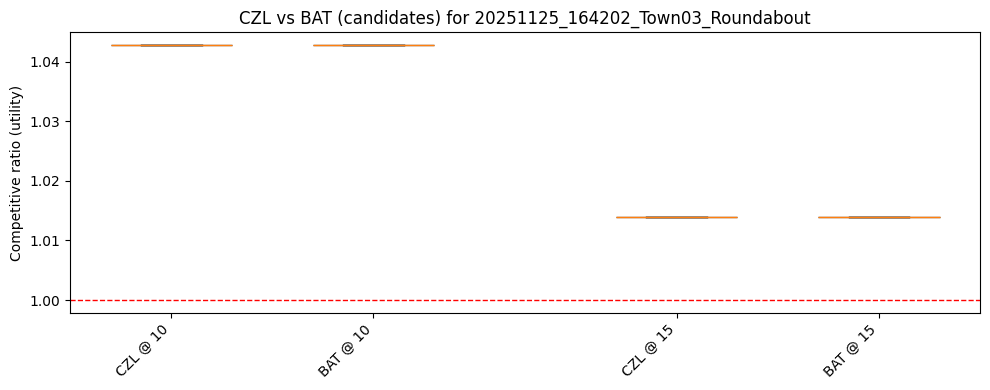

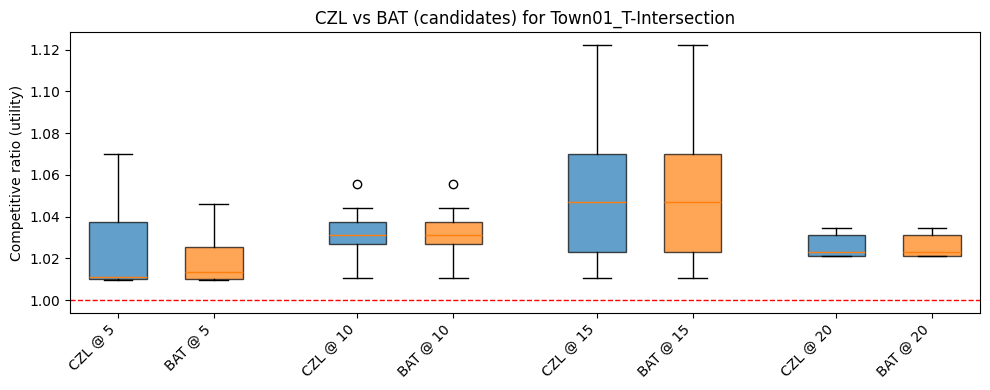

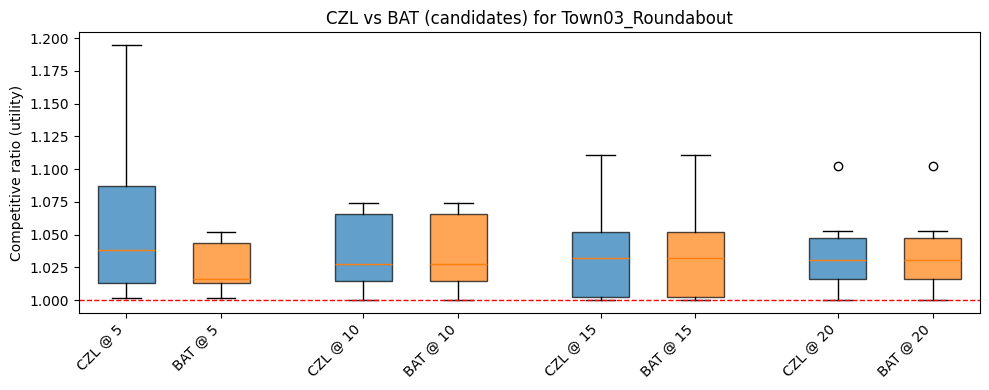

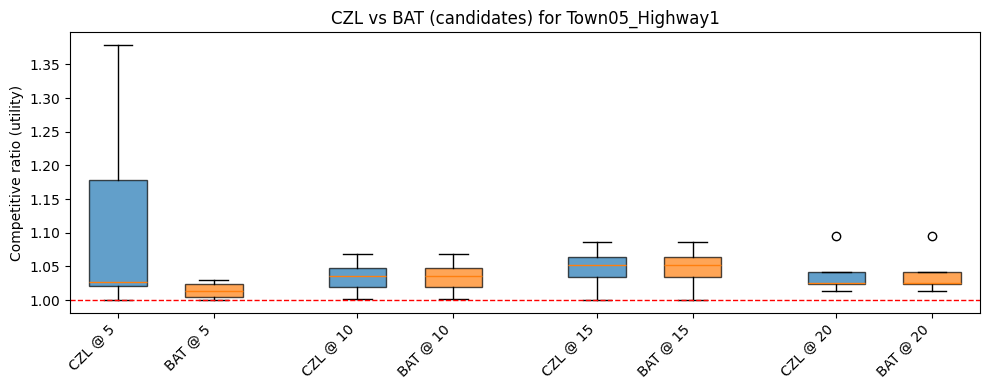

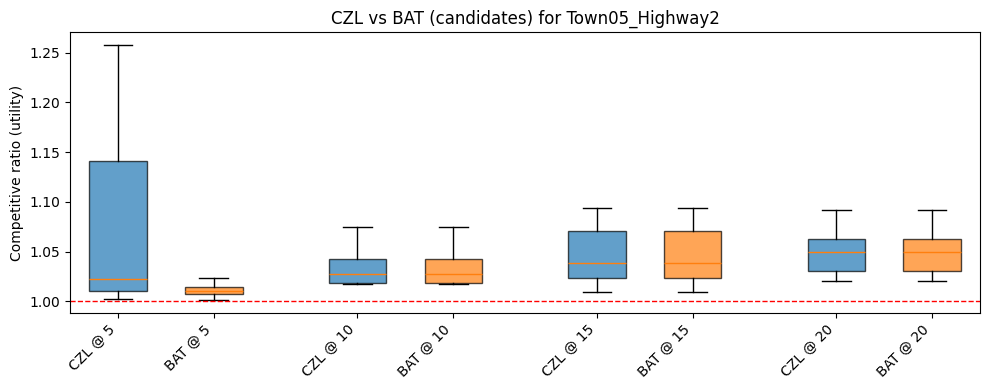

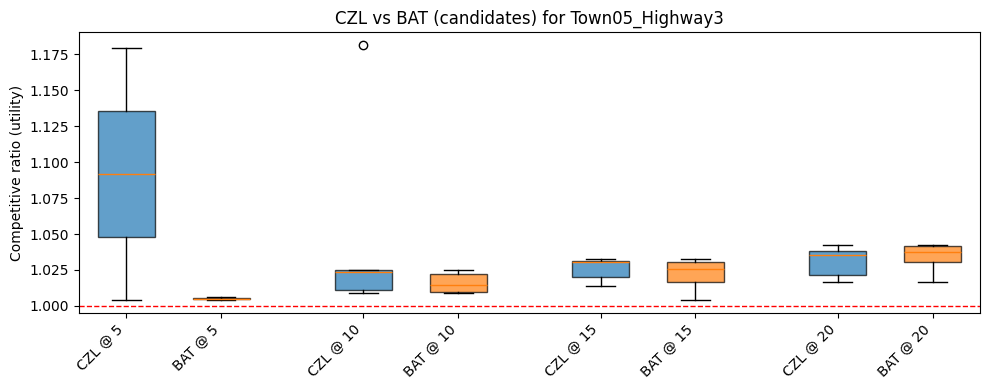

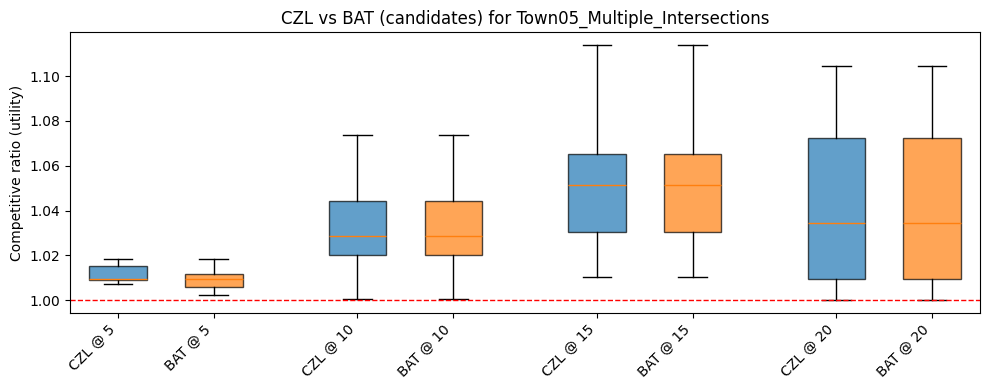

In [13]:

compare_df = long_df[(long_df['offline_ref'] == 'cand') & (long_df['algorithm'].isin(['CZL', 'BAT']))].copy()
if compare_df.empty:
    print('No candidate-based CZL/BAT rows found.')
else:
    colors = alg_colors if 'alg_colors' in globals() else {'CZL': '#1f77b4', 'BAT': '#ff7f0e'}
    def drop_outliers(series, k=1.5):
        if series.empty:
            return series
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - k * iqr, q3 + k * iqr
        return series[(series >= lo) & (series <= hi)]
    for scen in sorted(compare_df['scenario_name'].dropna().unique()):
        sub = compare_df[compare_df['scenario_name'] == scen]
        budgets = sorted([b for b in sub['budget'].dropna().unique()])
        if not budgets:
            print(f'Skipping {scen}: no budgets found.')
            continue
        data, positions, labels, label_algs = [], [], [], []
        pos = 1
        for b in budgets:
            for alg in ['CZL', 'BAT']:
                vals = sub[(sub['budget'] == b) & (sub['algorithm'] == alg)]['cr'].dropna()
                vals = drop_outliers(vals)
                if vals.empty:
                    continue
                data.append(vals)
                positions.append(pos)
                labels.append(f"{alg} @ {int(b) if b.is_integer() else b}")
                label_algs.append(alg)
                pos += 1
            pos += 0.5
        if not data:
            print(f'Skipping {scen}: no CZL/BAT CR values after filtering.')
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch, alg in zip(bp['boxes'], label_algs):
            patch.set_facecolor(colors.get(alg, '#888888'))
            patch.set_alpha(0.7)
        plt.axhline(1.0, color='red', linestyle='--', linewidth=1)
        plt.xticks(positions, labels, rotation=45, ha='right')
        plt.ylabel('Competitive ratio (utility)')
        plt.title(f'CZL vs BAT (candidates) for {scen}')
        plt.tight_layout()
        plt.show()


# ITM competitive ratios (candidates-only)
Box plots for ITM using candidates-based offline reference; outliers removed via IQR fence.

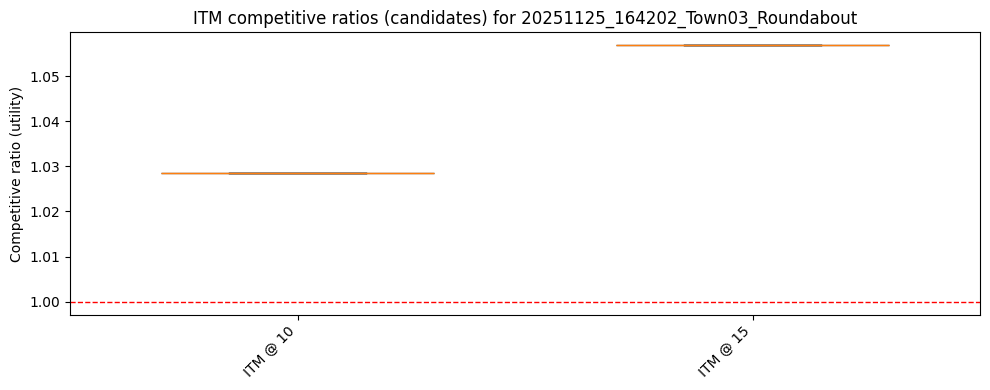

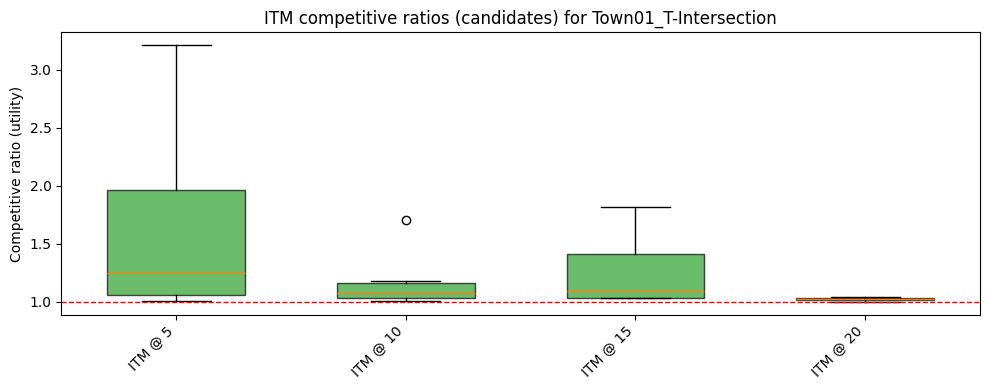

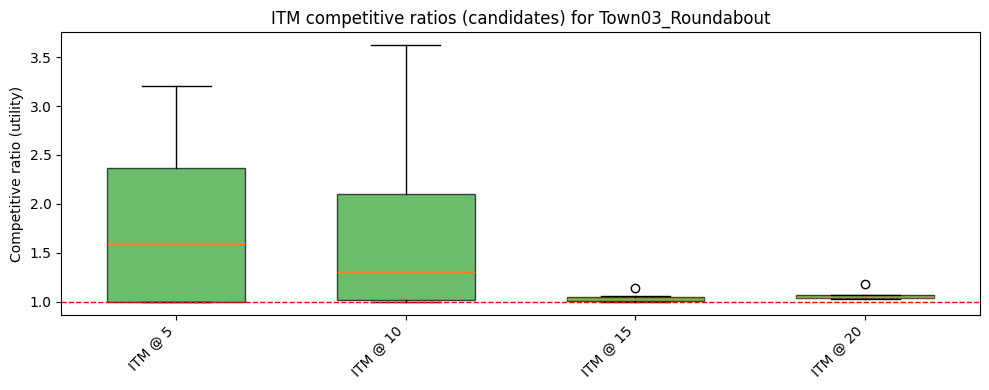

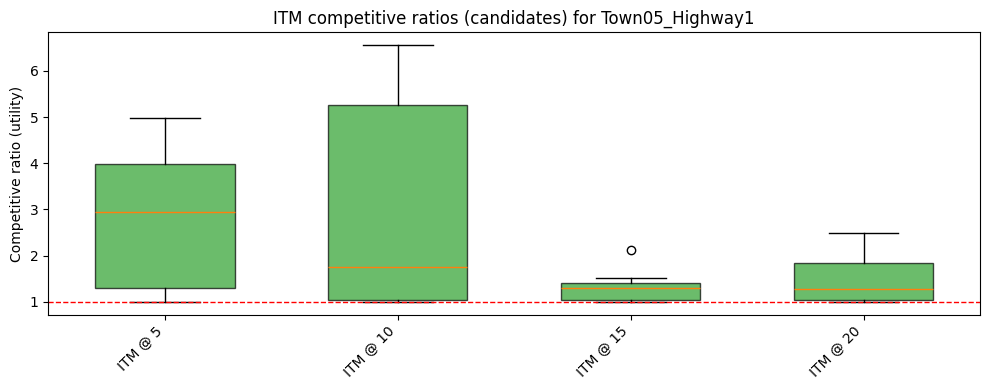

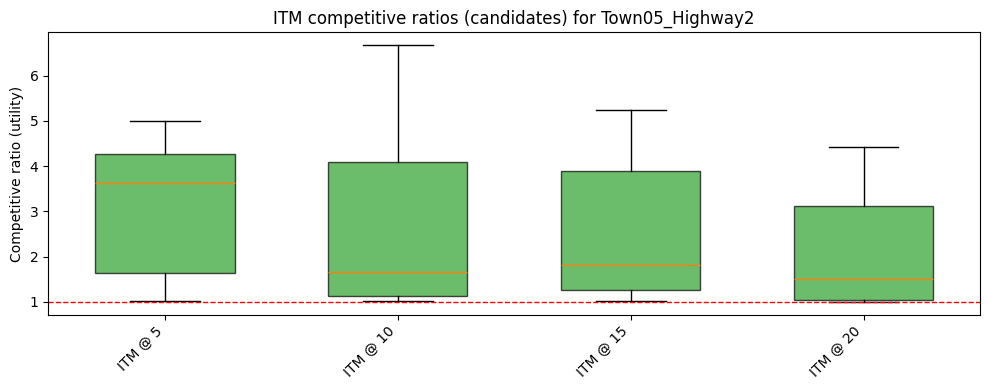

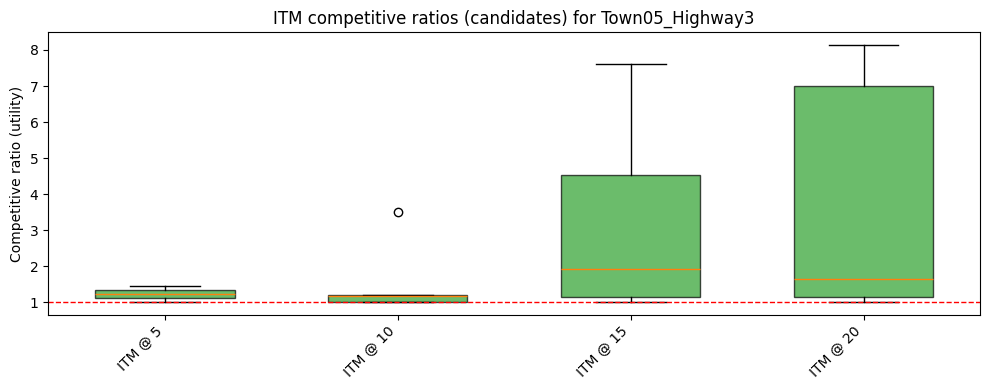

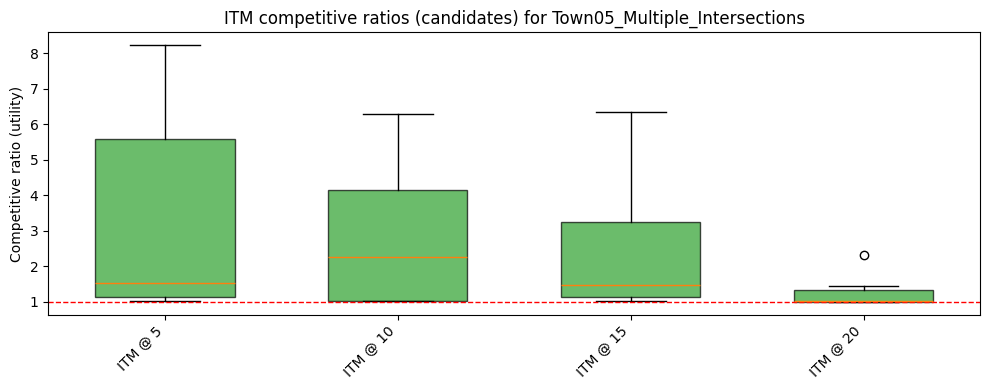

In [14]:

# ITM only, candidates-based reference
itm_df = long_df[(long_df['offline_ref'] == 'cand') & (long_df['algorithm'] == 'ITM')].copy()
if itm_df.empty:
    print('No candidate-based ITM rows found.')
else:
    color = '#2ca02c'
    def drop_outliers(series, k=1.5):
        if series.empty:
            return series
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - k * iqr, q3 + k * iqr
        return series[(series >= lo) & (series <= hi)]
    for scen in sorted(itm_df['scenario_name'].dropna().unique()):
        sub = itm_df[itm_df['scenario_name'] == scen]
        budgets = sorted([b for b in sub['budget'].dropna().unique()])
        data, positions, labels = [], [], []
        pos = 1
        for b in budgets:
            vals = sub[sub['budget'] == b]['cr'].dropna()
            vals = drop_outliers(vals)
            if vals.empty:
                continue
            data.append(vals)
            positions.append(pos)
            labels.append(f"ITM @ {int(b) if b.is_integer() else b}")
            pos += 1
        if not data:
            print(f'Skipping {scen}: no ITM CR values after filtering.')
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        plt.axhline(1.0, color='red', linestyle='--', linewidth=1)
        plt.xticks(positions, labels, rotation=45, ha='right')
        plt.ylabel('Competitive ratio (utility)')
        plt.title(f'ITM competitive ratios (candidates) for {scen}')
        plt.tight_layout()
        plt.show()


# Theoretical CZL competitive ratio
Compute the bound based on candidate sets: CR_czl <= ln(rho_max / rho_min) + 2 (rho = utility / risk).

In [15]:

import math
from motion_planning.online_algorithms.thresholds import czl_thresholds

cand_files = sorted((OFFLINE_RESULTS_DIR / "problem details").glob("*_candidates.csv"))

# Reuse parse_meta/risk labels if available; otherwise define a minimal parser.
risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_meta_with_risk(stem: str):
    if 'parse_meta' in globals():
        scen, budget = parse_meta(stem)
    else:
        parts = stem.split("_")
        scen, budget = stem, None
        for i, p in enumerate(parts):
            if p.lower() in risk_labels_local and i >= 1:
                scen = "_".join(parts[: i - 1]) or stem
                try:
                    budget = float(parts[i - 1])
                except Exception:
                    budget = None
                break
    parts = stem.split("_")
    risk = next((p for p in parts[::-1] if p.lower() in risk_labels_local), None)
    return scen, budget, risk

rows = []
for f in cand_files:
    stem = f.stem.replace("_candidates", "")
    try:
        rho_min, rho_max, _ = czl_thresholds([f])
    except Exception as exc:  # safety if file is empty or risks are 0
        print(f"Skip {f.name}: {exc}")
        continue
    scen, budget, risk = _parse_meta_with_risk(stem)
    bound = math.log(rho_max / rho_min) + 2
    rows.append({
        "file": f.name,
        "scenario": scen,
        "budget": budget,
        "risk": risk,
        "rho_min": rho_min,
        "rho_max": rho_max,
        "cr_czl_theoretical": bound,
    })

if not rows:
    print("No candidate files produced a theoretical bound.")
else:
    df_theory = pd.DataFrame(rows)
    display(df_theory.sort_values(["scenario", "budget", "risk"]))


,file,scenario,budget,risk,rho_min,rho_max,cr_czl_theoretical
0,20251125_164202_Town03_Roundabout_10_mid_5_can...,20251125_164202_Town03_Roundabout,10.0,mid,32.356929,88641.846050,9.915531
1,20251125_164202_Town03_Roundabout_15_mid_5_can...,20251125_164202_Town03_Roundabout,15.0,mid,31.740156,57718.800715,9.505756
14,iter1_Town01_T-Intersection_5_high_5_candidate...,Town01_T-Intersection,5.0,high,82.441546,1936.136808,5.156360
17,iter1_Town01_T-Intersection_5_very_high_5_cand...,Town01_T-Intersection,5.0,high,63.622648,603.209998,4.249296
109,iter2_Town01_T-Intersection_5_high_5_candidate...,Town01_T-Intersection,5.0,high,33.700703,4738.917602,6.946045
...,...,...,...,...,...,...,...
184,iter2_Town05_Multiple_Intersections_20_very_hi...,Town05_Multiple_Intersections,20.0,high,33.687959,567.935563,4.824867
90,iter1_Town05_Multiple_Intersections_20_low_5_c...,Town05_Multiple_Intersections,20.0,low,1461.764910,98799.999802,6.213453
182,iter2_Town05_Multiple_Intersections_20_low_5_c...,Town05_Multiple_Intersections,20.0,low,63.813974,98793.552351,9.344815
91,iter1_Town05_Multiple_Intersections_20_medium_...,Town05_Multiple_Intersections,20.0,medium,43.079412,98773.088769,9.737535


In [20]:
df_theory["cr_czl_theoretical"].min()

4.22850742589976

# Risk consumption (total risk)
Box plot of total risk consumed by CZL, BAT, and ITM solutions at a chosen budget (example: 5).

/tmp/ipykernel_7667/2622726091.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=algs, widths=0.6, patch_artist=True)


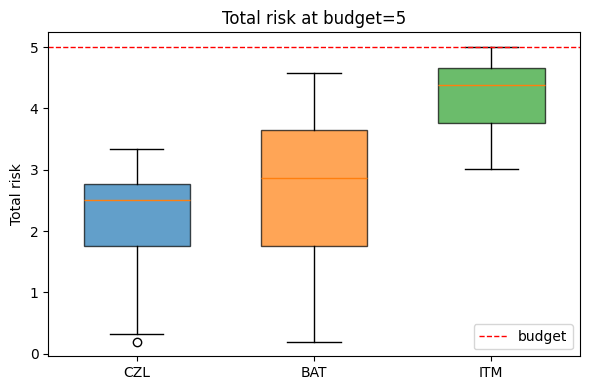

In [21]:

import math

# Change this to inspect a different budget
budget_target = 5
risk_cols = {
    'CZL': 'online_czl.total_risk',
    'BAT': 'online_bat.total_risk',
    'ITM': 'online_itm.total_risk',
}

# Use existing parse_meta if present; otherwise fall back to a minimal parser
risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_budget(stem: str):
    if 'parse_meta' in globals():
        scen, budget = parse_meta(stem)
        return scen, budget
    parts = stem.split('_')
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
    if risk_idx is None or risk_idx < 1:
        return stem, None
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
    scenario = '_'.join(scen_parts) or stem
    try:
        budget = float(parts[risk_idx - 1])
    except Exception:
        budget = None
    return scenario, budget

rows = []
for _, row in df_cr.iterrows():
    scen, bud = _parse_budget(row['scenario'])
    if bud is None or bud != budget_target:
        continue
    for alg, col in risk_cols.items():
        val = row.get(col)
        if val is None or pd.isna(val):
            continue
        rows.append({
            'scenario': scen,
            'budget': bud,
            'algorithm': alg,
            'total_risk': float(val),
        })

if not rows:
    print(f'No total risk rows found for budget={budget_target}.')
else:
    risk_df = pd.DataFrame(rows)
    plt.figure(figsize=(6, 4))
    algs = ['CZL', 'BAT', 'ITM']
    data = [risk_df[risk_df['algorithm'] == alg]['total_risk'] for alg in algs]
    bp = plt.boxplot(data, labels=algs, widths=0.6, patch_artist=True)
    colors = alg_colors if 'alg_colors' in globals() else {'CZL': '#1f77b4', 'BAT': '#ff7f0e', 'ITM': '#2ca02c'}
    for patch, alg in zip(bp['boxes'], algs):
        patch.set_facecolor(colors.get(alg, '#888888'))
        patch.set_alpha(0.7)
    plt.axhline(budget_target, color='red', linestyle='--', linewidth=1, label='budget')
    plt.ylabel('Total risk')
    plt.title(f'Total risk at budget={budget_target}')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Risk consumption by scenario/budget
Box plots of total risk for CZL, BAT, and ITM across all scenarios and budgets (candidates-based runs).

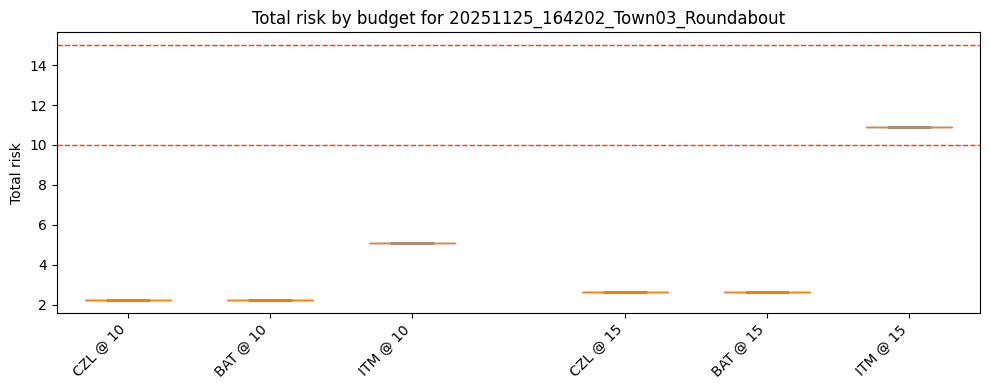

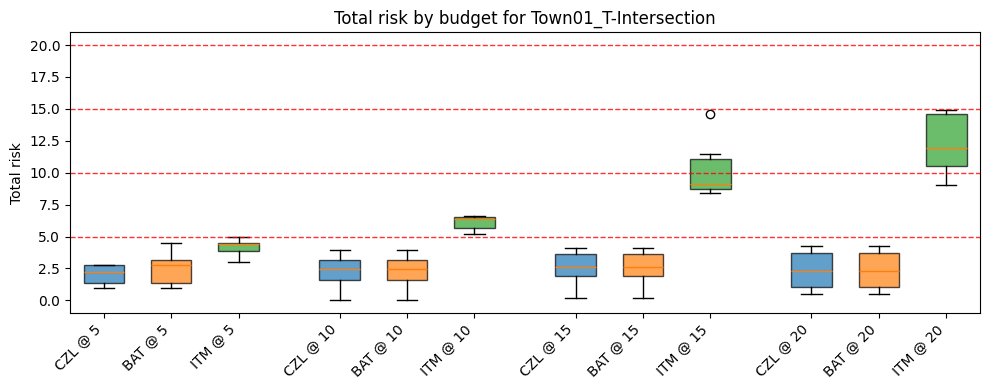

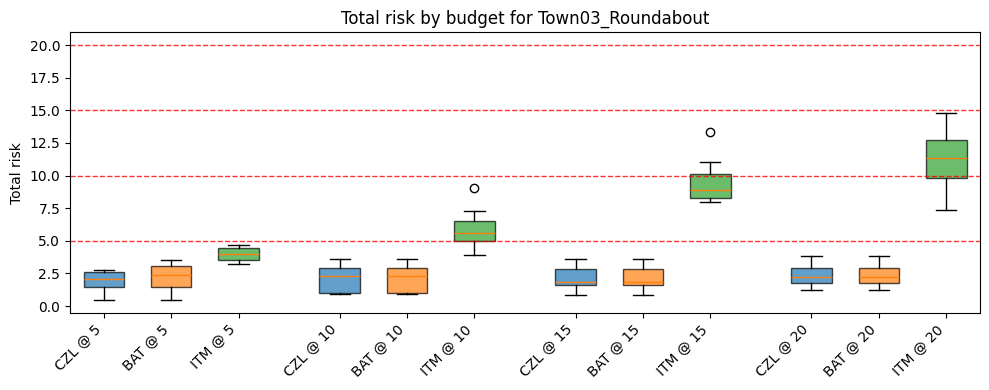

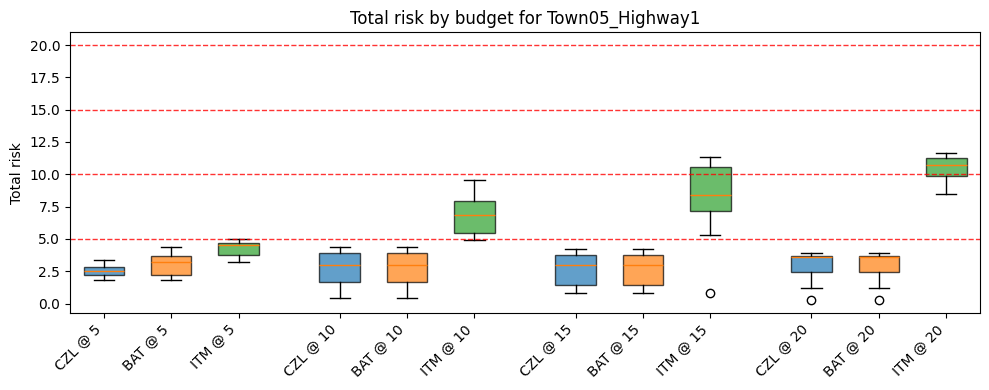

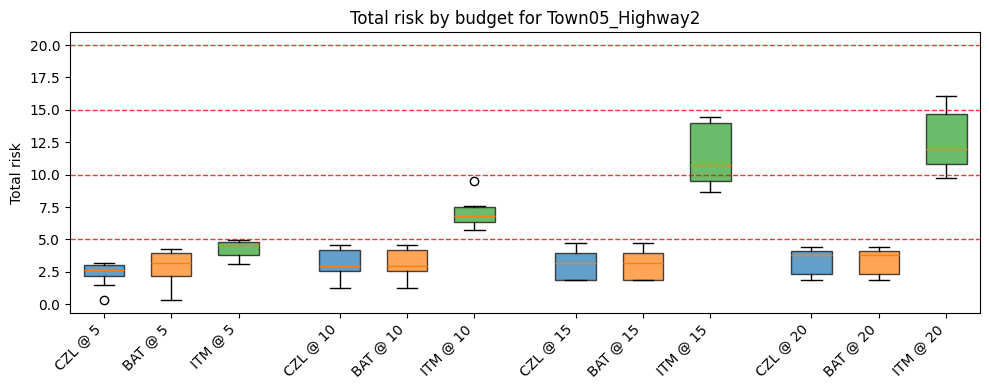

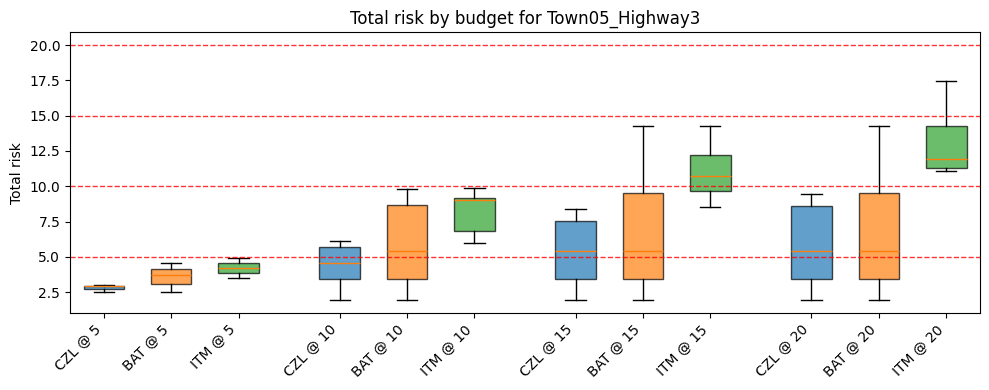

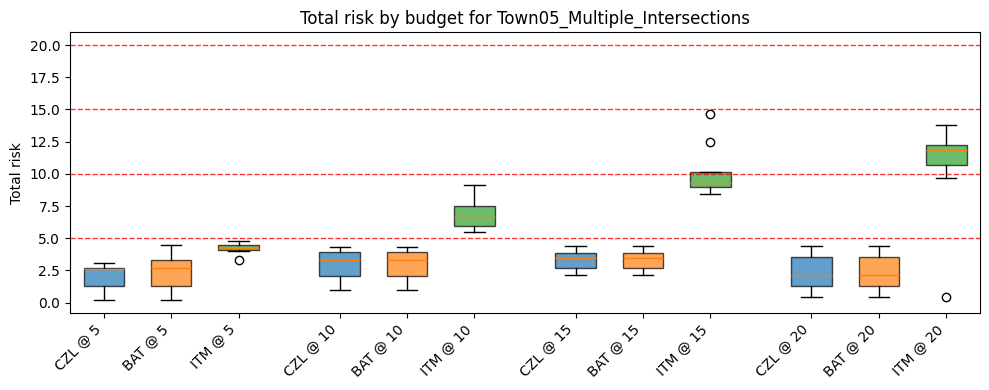

In [23]:

import math

risk_cols = {
    'CZL': 'online_czl.total_risk',
    'BAT': 'online_bat.total_risk',
    'ITM': 'online_itm.total_risk',
}
colors = alg_colors if 'alg_colors' in globals() else {'CZL': '#1f77b4', 'BAT': '#ff7f0e', 'ITM': '#2ca02c'}

risk_labels_local = risk_labels if 'risk_labels' in globals() else {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def _parse_meta_risk(stem: str):
    if 'parse_meta' in globals():
        scen, budget = parse_meta(stem)
    else:
        parts = stem.split('_')
        risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels_local), None)
        if risk_idx is None or risk_idx < 1:
            return stem, None
        scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
        scen = '_'.join(scen_parts) or stem
        try:
            budget = float(parts[risk_idx - 1])
        except Exception:
            budget = None
    return scen, budget

records = []
for _, r in df_cr.iterrows():
    scen, bud = _parse_meta_risk(r['scenario'])
    if bud is None:
        continue
    for alg, col in risk_cols.items():
        val = r.get(col)
        if val is None or pd.isna(val):
            continue
        records.append({
            'scenario': scen,
            'budget': bud,
            'algorithm': alg,
            'total_risk': float(val),
        })

if not records:
    print('No total risk rows found.')
else:
    risk_df = pd.DataFrame(records)
    for scen in sorted(risk_df['scenario'].dropna().unique()):
        sub = risk_df[risk_df['scenario'] == scen]
        budgets = sorted(sub['budget'].dropna().unique())
        data, positions, labels, label_algs = [], [], [], []
        pos = 1
        for b in budgets:
            for alg in ['CZL', 'BAT', 'ITM']:
                vals = sub[(sub['budget'] == b) & (sub['algorithm'] == alg)]['total_risk'].dropna()
                if vals.empty:
                    continue
                data.append(vals)
                positions.append(pos)
                labels.append(f"{alg} @ {int(b) if float(b).is_integer() else b}")
                label_algs.append(alg)
                pos += 1
            pos += 0.5  # gap between budgets
        if not data:
            print(f'Skipping {scen}: no risk rows after filtering.')
            continue
        plt.figure(figsize=(10, 4))
        bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
        for patch, alg in zip(bp['boxes'], label_algs):
            patch.set_facecolor(colors.get(alg, '#888888'))
            patch.set_alpha(0.7)
        for b in budgets:
            plt.axhline(b, color='red', linestyle='--', linewidth=1, alpha=0.8)
        plt.xticks(positions, labels, rotation=45, ha='right')
        plt.ylabel('Total risk')
        plt.title(f'Total risk by budget for {scen}')
        plt.tight_layout()
        plt.show()
